In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import gensim.downloader as api
from sklearn.model_selection import train_test_split

In [2]:
columns = []
with open("./data/KDDCUP/kddcup.names") as f:
    next(f, None)
    for line in f:
        parts = line.strip().split(":")
        if parts:
            columns.append(parts[0].strip())
columns.append("target")
print("Columns: {}".format( len(columns)))
print(columns)

Columns: 42
['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'target']


In [3]:
attack_types = {}
with open("./data/KDDCUP/training_attack_types") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 2:
            attack_types[parts[0]] = parts[1]
attack_types["normal"] = "normal"
print("Attack Types")
pprint(attack_types)

Attack Types
{'back': 'dos',
 'buffer_overflow': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'imap': 'r2l',
 'ipsweep': 'probe',
 'land': 'dos',
 'loadmodule': 'u2r',
 'multihop': 'r2l',
 'neptune': 'dos',
 'nmap': 'probe',
 'normal': 'normal',
 'perl': 'u2r',
 'phf': 'r2l',
 'pod': 'dos',
 'portsweep': 'probe',
 'rootkit': 'u2r',
 'satan': 'probe',
 'smurf': 'dos',
 'spy': 'r2l',
 'teardrop': 'dos',
 'warezclient': 'r2l',
 'warezmaster': 'r2l'}


In [4]:
path_kdd = "./data/KDDCUP/kddcup.data_10_percent.gz"
df_kdd_raw = pd.read_csv(path_kdd, names=columns)
print("Shape: {}".format(df_kdd_raw.shape))
df_kdd_raw.head()

Shape: (494021, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [5]:
def plot_distribution_attack_type(df):
    df['rolling_mean'] = df['Temp_Count'].rolling(window=5000).mean()
    plt.figure(figsize=(15, 5))
    df['rolling_mean'].plot()
    plt.title('Rolling Mean of Labels (Window Size = 1000)')
    plt.xlabel('Record Index')
    plt.ylabel('Average Label')
    plt.show()

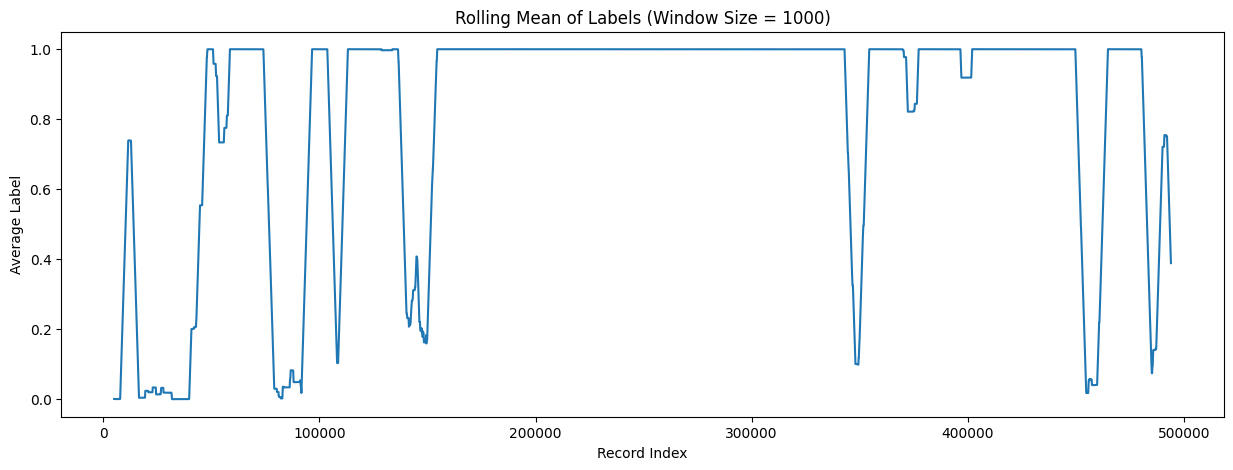

In [6]:
df_kdd_raw['Temp_Count'] = (df_kdd_raw['target'] != 'normal.').astype(int)
plot_distribution_attack_type(df_kdd_raw)
df_kdd_raw = df_kdd_raw.drop(['rolling_mean'], axis=1)
df_kdd_raw = df_kdd_raw.drop(['Temp_Count'], axis=1)

In [7]:
df_kdd_shuffled = df_kdd_raw.sample(frac = 1).reset_index(drop=True)
df_kdd_shuffled.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
1,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
2,0,tcp,private,S0,0,0,0,0,0,0,...,4,0.02,0.07,0.0,0.0,1.0,1.0,0.0,0.0,neptune.
3,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
4,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.


In [8]:
y = df_kdd_shuffled[['target']]
X = df_kdd_shuffled.drop(columns=['target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
print("X Type: {} Shape: {}".format(type(X), X.shape))
print("y Type: {} Shape: {}".format(type(y), y.shape))

print("X_train Type: {} Shape: {}".format(type(X_train), X_train.shape))
print("y_train Type: {} Shape: {}".format(type(y_train), y_train.shape))

print("X_test Type: {} Shape: {}".format(type(X_test), X_test.shape))
print("y_test Type: {} Shape: {}".format(type(y_test), y_test.shape))

X Type: <class 'pandas.core.frame.DataFrame'> Shape: (494021, 41)
y Type: <class 'pandas.core.frame.DataFrame'> Shape: (494021, 1)
X_train Type: <class 'pandas.core.frame.DataFrame'> Shape: (395216, 41)
y_train Type: <class 'pandas.core.frame.DataFrame'> Shape: (395216, 1)
X_test Type: <class 'pandas.core.frame.DataFrame'> Shape: (98805, 41)
y_test Type: <class 'pandas.core.frame.DataFrame'> Shape: (98805, 1)


In [10]:
streamingInputData = pd.concat([X_test, y_test], axis=1)
streamingInputData.shape

(98805, 42)

In [11]:
streamingInputData.to_csv("./data/KDDCUP/streamingInputData.csv", index=False, header=False)

In [12]:
df_kdd = pd.concat([X_train, y_train], axis=1)

In [13]:
def lookup_attack(attack):
    return attack_types[attack[:-1]] # strips the "." at "
df_kdd['Attack Type'] = df_kdd.target.apply(lookup_attack)

In [14]:
df_kdd["target"].value_counts()

smurf.              224660
neptune.             85746
normal.              77794
back.                 1777
satan.                1266
ipsweep.              1000
portsweep.             825
warezclient.           809
teardrop.              804
pod.                   205
nmap.                  189
guess_passwd.           39
buffer_overflow.        23
land.                   19
warezmaster.            15
imap.                    8
loadmodule.              8
ftp_write.               7
multihop.                7
rootkit.                 7
phf.                     4
perl.                    2
spy.                     2
Name: target, dtype: int64

In [15]:
numeric_features = df_kdd.select_dtypes(include=[np.number])
numeric_features.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,395216.000000,3.952160e+05,3.952160e+05,395216.000000,395216.000000,395216.000000,395216.000000,395216.000000,395216.000000,395216.000000,...,395216.000000,395216.000000,395216.000000,395216.000000,395216.000000,395216.000000,395216.000000,395216.000000,395216.000000,395216.000000
mean,47.679310,3.377267e+03,8.653285e+02,0.000048,0.006581,0.000013,0.034374,0.000129,0.148251,0.009587,...,232.430405,188.688059,0.753866,0.030880,0.602028,0.006705,0.176581,0.176260,0.058329,0.057594
std,709.087747,1.104470e+06,3.268149e+04,0.006933,0.136575,0.005735,0.780492,0.012625,0.355349,1.597336,...,64.814004,106.030421,0.410728,0.109219,0.481288,0.042282,0.380447,0.380768,0.231009,0.230457
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,3.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
non_numeric_features = df_kdd.select_dtypes(exclude=[np.number])
non_numeric_features.columns

Index(['protocol_type', 'service', 'flag', 'target', 'Attack Type'], dtype='object')

In [17]:
non_numeric_features.describe()

,protocol_type,service,flag,target,Attack Type
count,395216,395216,395216,395216,395216
unique,3,66,11,23,5
top,icmp,ecr_i,SF,smurf.,dos
freq,226906,225157,302725,224660,313211


In [18]:
def plot_df_feature(dataframe, feature, type):
    dataframe[feature].value_counts().plot(kind=type)

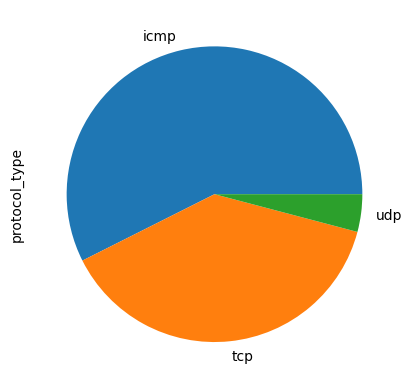

In [19]:
plot_df_feature(df_kdd, "protocol_type", "pie")

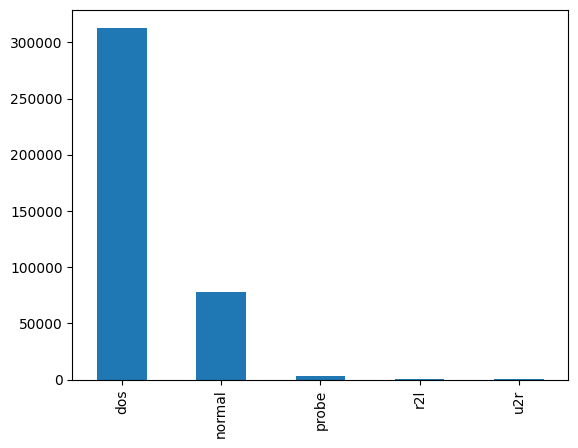

In [20]:
plot_df_feature(df_kdd, "Attack Type", "bar")

In [21]:
# removing non-unique and NaN columns
df_kdd = df_kdd.dropna(axis='columns')
df_kdd = df_kdd.loc[:, df_kdd.nunique(dropna=False) > 1]
df_kdd.shape

(395216, 41)

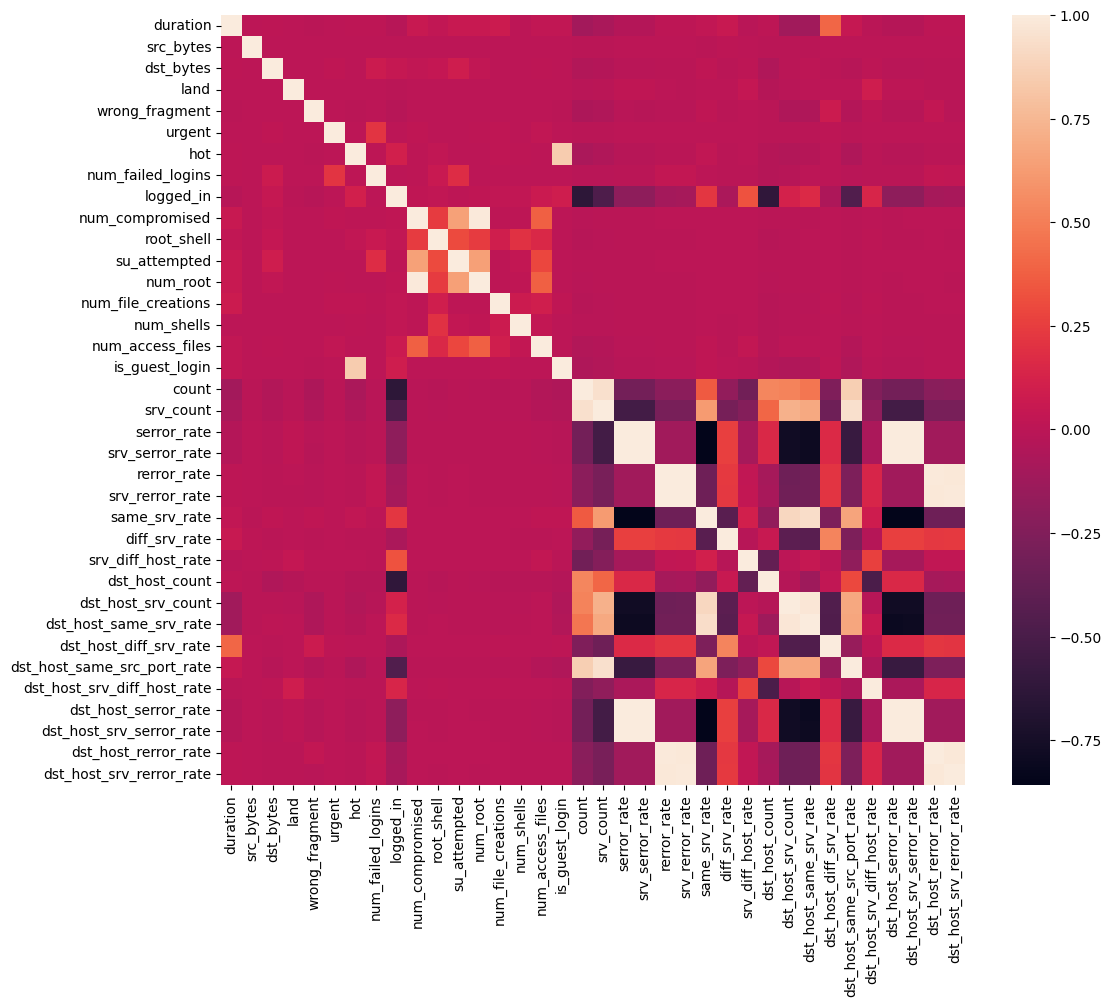

In [22]:
corr = df_kdd.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr)
plt.show() 

In [23]:
# embeddingModel = api.load('glove-twitter-25')
# def get_embedding_mean(word):
#     try:
#         return np.mean(embeddingModel[word])
#     except:
#         return 0.0

In [24]:
protocolTypeEmbedding = {'icmp':0,'tcp':1,'udp':2}
df_kdd['protocol_type'] = df_kdd['protocol_type'].map(protocolTypeEmbedding)

flagEmbedding = {'SF':0,'S0':1,'REJ':2,'RSTR':3,'RSTO':4,'SH':5 ,'S1':6 ,'S2':7,'RSTOS0':8,'S3':9 ,'OTH':10}
df_kdd['flag'] = df_kdd['flag'].map(flagEmbedding)

df_kdd.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,Attack Type
62172,0,0,ecr_i,0,1032,0,0,0,0,0,...,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.,dos
153334,0,0,ecr_i,0,520,0,0,0,0,0,...,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.,dos
455102,0,0,ecr_i,0,1032,0,0,0,0,0,...,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.,dos
326043,0,1,private,1,0,0,0,0,0,0,...,0.02,0.08,0.00,0.00,1.0,1.0,0.0,0.0,neptune.,dos
354129,0,1,http,0,339,5255,0,0,0,0,...,1.00,0.00,0.07,0.04,0.0,0.0,0.0,0.0,normal.,normal


In [25]:
# non_number_cols = ['protocol_type', 'service', 'flag', 'target']

# for col in non_number_cols:
#     df_kdd[col] = df_kdd[col].apply(get_embedding_mean)

In [26]:
df_kdd = df_kdd.drop(['target'], axis=1)
df_kdd = df_kdd.drop(['service'], axis=1)

df_kdd['Attack Type'] = (df_kdd['Attack Type'] != 'normal').astype(int)
df_kdd.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Attack Type
62172,0,0,0,1032,0,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,1
153334,0,0,0,520,0,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,1
455102,0,0,0,1032,0,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,1
326043,0,1,1,0,0,0,0,0,0,0,...,6,0.02,0.08,0.00,0.00,1.0,1.0,0.0,0.0,1
354129,0,1,0,339,5255,0,0,0,0,0,...,255,1.00,0.00,0.07,0.04,0.0,0.0,0.0,0.0,0


In [27]:
y = df_kdd[['Attack Type']]
X = df_kdd.drop(columns=['Attack Type'], axis=1)

In [29]:
df_preprocessed = pd.concat([pd.DataFrame(X), y], axis=1)
df_preprocessed.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Attack Type
62172,0,0,0,1032,0,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,1
153334,0,0,0,520,0,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,1
455102,0,0,0,1032,0,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,1
326043,0,1,1,0,0,0,0,0,0,0,...,6,0.02,0.08,0.00,0.00,1.0,1.0,0.0,0.0,1
354129,0,1,0,339,5255,0,0,0,0,0,...,255,1.00,0.00,0.07,0.04,0.0,0.0,0.0,0.0,0


In [30]:
df_preprocessed.to_pickle("./data/KDDCUP/KDDCUP_DF_Preprocessed.pkl")